In [376]:
import numpy as np
from cooltools.eigdecomp import cis_eig
import cooler
import pandas as pd


## Compartment analysis

In [188]:
#To get the interaction matrix
cool = cooler.Cooler('/Users/cmdb/qbb2021-answers/qbio-week6/hw/K562_hg19_chr3_50K.cool')
mat = cool.matrix(balance=True)[:]

#To get the signal track file
GC_pd = pd.read_csv("/Users/cmdb/qbb2021-answers/qbio-week6/hw/hg19_GC_chr3_50K.txt", header=None)
signal_track = np.array(GC_pd[0].values.tolist())

In [189]:
# Get the first eigenvector that indicates the nuclear compartment
nuclear_comp = cis_eig(mat, n_eigs = 1, phasing_track=signal_track)
compartmen_score = [x for x in nuclear_comp[1][0] if np.isnan(x) == False]

In [219]:
# To calculate the median score of alll of the nonzero interactions
inter_score = [x for x in mat[1] if x != 0 and np.isnan(x) == False]
median_inter = np.median(inter_score)


/Users/cmdb/miniconda3/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


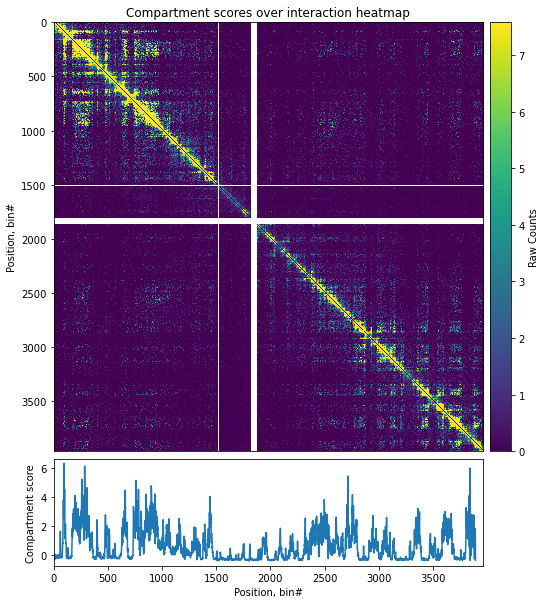

In [104]:
#the interaction matrix
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import make_axes_locatable

fig, ax = plt.subplots(
    figsize=(10,10))
#vmax is defined as 10 times of of the median score of all of the nonzero interactions
im = ax.matshow(mat, vmax = 10*median_inter)

divider = make_axes_locatable(ax)
#show the interaction matrix
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, fraction = 0.046, pad = 0.04, cax = cax, label = 'Raw Counts')
ax.set(xlabel = "Position, bin#", ylabel = "Position, bin#")
ax.xaxis.set_visible(False)

#show the relationship between eigen vector scores and compartment patterns (compartment scores over heatmap)
ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
ax1.plot(compartmen_score)
ax1. set_ylabel("Compartment score")
ax1.set_xlabel("Position, bin#")

ax.set_title("Compartment scores over interaction heatmap")


fig.show()

In [446]:
df = pd.DataFrame(nuclear_comp[1][0], columns=["First eigenvalue"])
df.at[df["First eigenvalue"] > 0, "Compartment"] = "A" #set the row with positive eigenvalues as A compartment
df.at[df["First eigenvalue"] <= 0, "Compartment"] = "B" #set the row with negative eigenvalues as A compartment

In [447]:
#Add the chromosome start and end position
df["Start"] = np.linspace(0, 50000*(len(nuclear_comp[1][0])-1), num = len(nuclear_comp[1][0]), dtype = int)
df["End"] = np.linspace(50000, 50000*(len(nuclear_comp[1][0])), num = len(nuclear_comp[1][0]), dtype = int)
df["Chr"] = "chr3"

#Change the relative position
compartment_df = df.iloc[:, [4,2,3,0,1]]

In [448]:
#store as a bed file

#Drop all rows with nan compartment values
compartment_df = compartment_df.dropna()
#Output as a bedfile
compartment_df.to_csv(sep = "\t", path_or_buf = "/Users/cmdb/qbb2021-answers/qbio-week6/hw/compartment.bed", index=False, header=None)

In [450]:
compartment_df.head()

,Chr,Start,End,First eigenvalue,Compartment
1,chr3,50000,100000,-0.079311,B
2,chr3,100000,150000,0.083915,A
3,chr3,150000,200000,0.020302,A
4,chr3,200000,250000,-0.004100,B
5,chr3,250000,300000,-0.017986,B


In [417]:
#another method
# compartment1_df = cool.bins()[:]
# compartment1_df ["Eigen val"] = nuclear_comp[1][0]
# compartment1_df.at[compartment1_df["Eigen val"] > 0, "Compartment"] = "A"
# compartment1_df.at[compartment1_df["Eigen val"] <=0, "Compartment"] = "B"
# compartment1_df["chrom"] = "chr3"
# compartment1_df = compartment1_df[["chrom", "start", "end", "Compartment"]]


## Expression vs. Repression

In [401]:
expression_df = pd.read_csv("/Users/cmdb/qbb2021-answers/qbio-week6/hw/K562_hg19_FPKM_chr3.bed", sep = "\t", names = ["chr","start", "end","gene", "expression", "strand"])

In [402]:
expression_df

,chr,start,end,gene,expression,strand
0,chr3,238279,451090,CHL1,0.00,+
1,chr3,1134260,1445901,CNTN6,0.00,+
2,chr3,2140497,3099645,CNTN4,0.01,+
3,chr3,3111233,3168297,IL5RA,0.14,-
4,chr3,3168600,3192563,TRNT1,25.28,+
...,...,...,...,...,...,...
1059,chr3,197464050,197514467,FYTTD1,53.14,+
1060,chr3,197518097,197615307,LRCH3,24.13,+
1061,chr3,197615946,197687013,IQCG,3.70,-
1062,chr3,197676858,197683481,RPL35A,1195.67,+


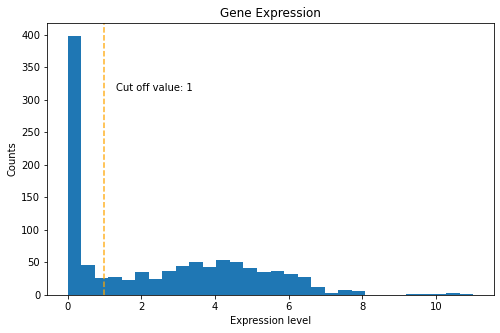

In [442]:
fig, ax = plt.subplots(
    figsize=(8,5))
ax.hist(np.log2(expression_df["expression"]+1), bins=30)
ax.set_ylabel("Counts")
ax.set_xlabel("Expression level")
ax.set_title("Gene Expression")
ax.axvline(x=1, color = 'orange', linestyle ='dashed', alpha =0.85)
max_ylim = plt.ylim()[1]

ax.text(1.3, max_ylim*0.75, "Cut off value: 1")


plt.show()


In [460]:
#Violin plot

#import the compartment mapping data

compmap_df = pd.read_csv("/Users/cmdb/qbb2021-answers/qbio-week6/hw/K562_hg19_FPKM_chr3_compartment_map.bed", sep='\t', names=["chr", "start","end","gene","expression","strand","H3K27me3","compartment"])

In [465]:
compmap_df.head()

,chr,start,end,gene,expression,strand,H3K27me3,compartment
0,chr3,238279,451090,CHL1,0.00,+,0.217979,.
1,chr3,1134260,1445901,CNTN6,0.00,+,0.212417,.
2,chr3,2140497,3099645,CNTN4,0.01,+,0.271694,.
3,chr3,3111233,3168297,IL5RA,0.14,-,1.567160,A
4,chr3,3168600,3192563,TRNT1,25.28,+,0.168837,A


In [462]:
#A compartment 

#Expression
A_exp = compmap_df[(np.log2(compmap_df["expression"]+1) >= 1) & (compmap_df["compartment"] == "A")]
A_exp_array = np.asarray(A_exp["H3K27me3"])
#Repression
A_rep = compmap_df[(np.log2(compmap_df["expression"]+1) < 1) & (compmap_df["compartment"] == "A")]
A_rep_array = np.asarray(A_rep["H3K27me3"])


#B compartment

#Expression
B_exp = compmap_df[(np.log2(compmap_df["expression"]+1) >= 1) & (compmap_df["compartment"] == "B")]
B_exp_array = np.asarray(B_exp["H3K27me3"])
#Repression
B_rep = compmap_df[(np.log2(compmap_df["expression"]+1) < 1) & (compmap_df["compartment"] == "B")]
B_rep_array = np.asarray(B_rep["H3K27me3"])



In [466]:
compa

,chr,start,end,gene,expression,strand,H3K27me3,compartment
505,chr3,96335981,96337000,MTRNR2L12,1.13,-,0.00000,B
878,chr3,160801671,160823172,B3GALNT1,1.04,-,1.22648,B


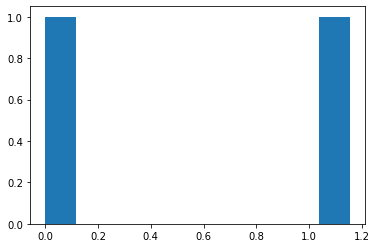

In [463]:
tmp = np.log2(B_exp_array+1)
fig, ax = plt.subplots()
ax.hist(tmp)
plt.show()

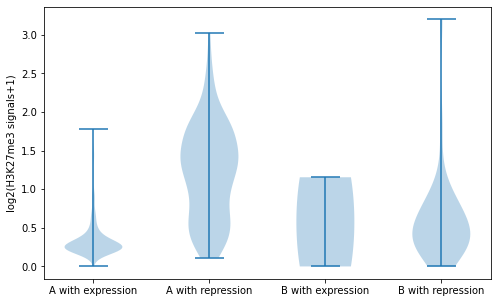

In [464]:
#data to plot
data_to_plot = [np.log2(A_exp_array+1), np.log2(A_rep_array+1), np.log2(B_exp_array+1), np.log2(B_rep_array+1)]

# Create a figure instance
fig, ax = plt.subplots(
    figsize=(8,5))

# Create the boxplot
ax.violinplot(data_to_plot)

ax.set_xticks(np.arange(4)+1)
ax.set_xticklabels(('A with expression', 'A with repression','B with expression', 'B with repression'))
ax.set_ylabel("log2(H3K27me3 signals+1)")

plt.show()